In [1]:
# -*- coding: utf-8 -*-

import functools
import numpy as np
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt


import pso
import ann
#activationLayer="tanh"
#np.random.seed(6663)
def dim_weights(shape):
    dim = 0
    
    for i in range(len(shape)-1):
        dim = dim + (shape[i] + 1) * shape[i+1]
    return dim

def weights_to_vector(weights):
    w = np.asarray([])
    for i in range(len(weights)):
        v = weights[i].flatten()
        w = np.append(w, v)
    return w

def vector_to_weights(vector, shape):
    weights = []
    idx = 0
    for i in range(len(shape)-1):
        r = shape[i+1]
        c = shape[i] + 1
        idx_min = idx
        idx_max = idx + r*c
        W = vector[idx_min:idx_max].reshape(r,c)
        weights.append(W)
    return weights



#this is the optimisation for the coords of the particles??
def eval_neural_network(weights, shape, X, y,activationLayer):
    mse = np.asarray([])
    for w in weights:
        weights = vector_to_weights(w, shape)
        nn = ann.MultiLayerPerceptron(shape, weights=weights)
        y_pred = nn.run(X,activationLayer)
        #print("eval network :",y.shape,y_pred.shape,X.shape)
        mse = np.append(mse, sklearn.metrics.mean_squared_error(y, y_pred))
    return mse

def print_best_particle(best_particle):
    print("New best particle found at iteration #{i} with mean squared error: {score}".format(i=best_particle[0], score=best_particle[1]))




#just xy error = 0.22938741634873416
#with sinx sin y error = 0.2325498216710004
#with sin and sq error = 0.21790465807135315

In [2]:

def sine(X):
    return np.sin(X)


#loading Starts here

def sq(X):
    return np.power(X,2)

num_classes = 2
f = open("two_spirals.dat","r")
data = np.loadtxt(f)
X = data[:,0:2]
y = data[:,2]
y = y.astype(int)

 

def generateData(X,y,ratio,sin=False,square=False):
    if sin and square:
        X = np.hstack((X,np.hstack((sq(X),sine(X)))))
      #  print(X[0])
    elif sin:
        X=np.hstack((X,sine(X)))
    elif square:
        X = np.hstack((X,sq(X)))
    train_test_split = int(ratio*len(y))
    X_train,X_test = X[:train_test_split],X[train_test_split:]
    y_train,y_test = y[:train_test_split],y[train_test_split:]  
    print(X_train[0])
    return X_train,X_test,y_train,y_test

# X,X_train,X_test,y_train,y_test=generateData(X,y,0.5,True,False)


# #so x train and y train are basically x and y in this file

# X = X_train
# y = y_train
# print(len(y_train))
# print(X_train.shape)


In [27]:
iterations = 40000

def runn(X,X_test,y,y_test,square,sin):
    
    # # Load MNIST digits from sklearn

    # num_classes = 10
    # mnist = sklearn.datasets.load_digits(num_classes)
    # X, X_test, y, y_test = sklearn.model_selection.train_test_split(mnist.data, mnist.target)

    num_inputs = X.shape[1]
    print("Number of inputs = ",num_inputs)
    y_true = np.zeros((len(y), num_classes))

    for i in range(len(y)):
        y_true[i, y[i]] = 1
      #  print(y_true[i],y[i])

    y_test_true = np.zeros((len(y_test), num_classes))
    for i in range(len(y_test)):
        y_test_true[i, y_test[i]] = 1

    # print("y test shap e= ", y_test.shape)
    # print("y true shape = ",y_true.shape)
    # print("y test true shape = ",y_test_true.shape)
    # print(X_test.shape)
    # print(X_train.shape)

    print(y_test_true.shape,y_true.shape)
    plt.rcParams["figure.figsize"] = (12,9)

    def training(shape,activationLayer,pop):
        print("input  :",X.shape,y_true.shape)
        cost_func = functools.partial(eval_neural_network, shape=shape, X=X, y=y_true.T,activationLayer=activationLayer)
        
        swarm = pso.ParticleSwarm(cost_func, num_dimensions=dim_weights(shape), num_particles=pop,chi=0.729845 ,phi_p=2.0550,phi_g=2.0550)
      #  swarm = pso.ParticleSwarm(cost_func, num_dimensions=dim_weights(shape), num_particles=40,chi=0.729845 ,phi_p=1.5,phi_g=0.9)

        # Train...
        i = 0
        best_scores = [(i, swarm.best_score)]
        #print_best_particle(best_scores[-1])

        trainingLoss = []
        testloss = []
        while swarm.best_score>1e-6 and i<iterations:
            swarm._update()
            i = i+1

            best_weights = vector_to_weights(swarm.g, shape)
            best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)
            y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)
            testError = sklearn.metrics.mean_squared_error((y_test_true.T),y_test_pred)
            trainingLoss.append(swarm.best_score)
            testloss.append(testError)

    #     print("Best train = ",best_scores[-1][1])
    #     print("Best test = ",testLoss[-1])
        best_weights = vector_to_weights(swarm.g, shape)
        best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)
        y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)

       # accuracyError = (sklearn.metrics.accuracy_score(y_test_true, y_test_pred.T))
       # print(f"Accuracy error for {activationLayer} = {accuracyError}")
    #     x1=[]
    #     y1=[]
    #     x2=[]
    #     y2=[]
    #     print(y_test_pred.shape)
    #     y_test_pred=y_test_pred.T
    #     for i in range(len(X_test)):
    #         if(y_test_pred[i][0]==1):
    #             x1.append(X[i][0])
    #             y1.append(X[i][1])
    #         else:
    #             x2.append(X[i][0])
    #             y2.append(X[i][1])
    #     plt.scatter(x1,y1,c="r")
    #     plt.scatter(x2,y2,c="b")
    #     plt.show()
        return testloss,y_test_pred

    activations = ['sigmoid']#,'tanh','relu','identity']#,'relu','default']
    #iterations = 10000

    def testRun():
        '''
        I want mse to be y axis
        I want neurons to be x axis
        then I will have 3 plots, tanh, sigmoid and relu?
        '''
        #shape = (num_inputs, 8, num_classes)

        neurons = [8]#4,5,6,7,8]
        arrays = np.zeros(shape=(len(activations),len(neurons),iterations))
        minError = 10000
        yArray=[]
        for i in range(len(arrays)):
            activationLayer = activations[i]
            for k in range(len(neurons)):
                shape = (num_inputs,neurons[k],num_classes)
                mse,ys = training(shape,activationLayer,40)
                arrays[i][k]=mse

                if mse[-1]<minError:
                    minError=mse[-1]
                    yArray=ys
                    print(activations[i])

                print(f"Activation = {activations[i].capitalize()} neurons = {neurons[k]} with mse of {mse[-1]} square = {square} and sine = {sin}")
         #   print(i)

        return arrays,yArray
    arrays,yArray = testRun()
    return arrays,yArray

In [26]:
X_train,X_test,y_train,y_test=generateData(X,y,0.5,False,False)
runn(X_train,X_test,y_train,y_test,False,False)

[ 4.47485    -0.89004    20.02428252  0.7921712  -0.97192002 -0.77709692]
Number of inputs =  6
(66, 2) (66, 2)
input  : (66, 6) (66, 2)


KeyboardInterrupt: 

In [63]:
X_train,X_test,y_train,y_test=generateData(X,y,0.5,False,True)
runn(X_train,X_test,y_train,y_test,False,True)

[ 4.47485    -0.89004    20.02428252  0.7921712 ]
Number of inputs =  4
(132, 2) (132, 2)
Activation = Sigmoid neurons = 4 with mse of 0.25757575757575757 square = False and sine = True
Activation = Sigmoid neurons = 5 with mse of 0.32196969696969696 square = False and sine = True
Activation = Sigmoid neurons = 6 with mse of 0.3106060606060606 square = False and sine = True
Activation = Sigmoid neurons = 7 with mse of 0.22348484848484848 square = False and sine = True
Activation = Sigmoid neurons = 8 with mse of 0.22727272727272727 square = False and sine = True
Activation = Tanh neurons = 4 with mse of 0.29924242424242425 square = False and sine = True
Activation = Tanh neurons = 5 with mse of 0.3977272727272727 square = False and sine = True
Activation = Tanh neurons = 6 with mse of 0.3446969696969697 square = False and sine = True
Activation = Tanh neurons = 7 with mse of 0.26136363636363635 square = False and sine = True
Activation = Tanh neurons = 8 with mse of 0.2196969696969697 

In [64]:
X_train,X_test,y_train,y_test=generateData(X,y,0.5,True,False)
run(X_train,X_test,y_train,y_test,True,False)

[ 4.47485    -0.89004    -0.97192002 -0.77709692]
Number of inputs =  4
(132, 2) (132, 2)
Activation = Sigmoid neurons = 4 with mse of 0.32196969696969696 square = True and sine = False
Activation = Sigmoid neurons = 5 with mse of 0.23863636363636365 square = True and sine = False
Activation = Sigmoid neurons = 6 with mse of 0.09848484848484848 square = True and sine = False
Activation = Sigmoid neurons = 7 with mse of 0.10227272727272728 square = True and sine = False
Activation = Sigmoid neurons = 8 with mse of 0.1856060606060606 square = True and sine = False
Activation = Tanh neurons = 4 with mse of 0.3068181818181818 square = True and sine = False
Activation = Tanh neurons = 5 with mse of 0.23106060606060605 square = True and sine = False
Activation = Tanh neurons = 6 with mse of 0.2159090909090909 square = True and sine = False
Activation = Tanh neurons = 7 with mse of 0.25 square = True and sine = False
Activation = Tanh neurons = 8 with mse of 0.26515151515151514 square = True 

In [28]:
X_train,X_test,y_train,y_test=generateData(X,y,0.5,True,True)
arrays,yArray= runn(X_train,X_test,y_train,y_test,True,True)

[  4.47485     -0.89004     20.02428252   0.7921712   -0.97192002
  -0.77709692  20.02428252   0.7921712  400.97189054   0.62753521
   0.94462853   0.60387963  -0.97192002  -0.77709692   0.9225844
   0.71187979  -0.82596958  -0.70121262]
Number of inputs =  18
(66, 2) (66, 2)
input  : (66, 18) (66, 2)
sigmoid
Activation = Sigmoid neurons = 8 with mse of 0.5151515151515151 square = True and sine = True


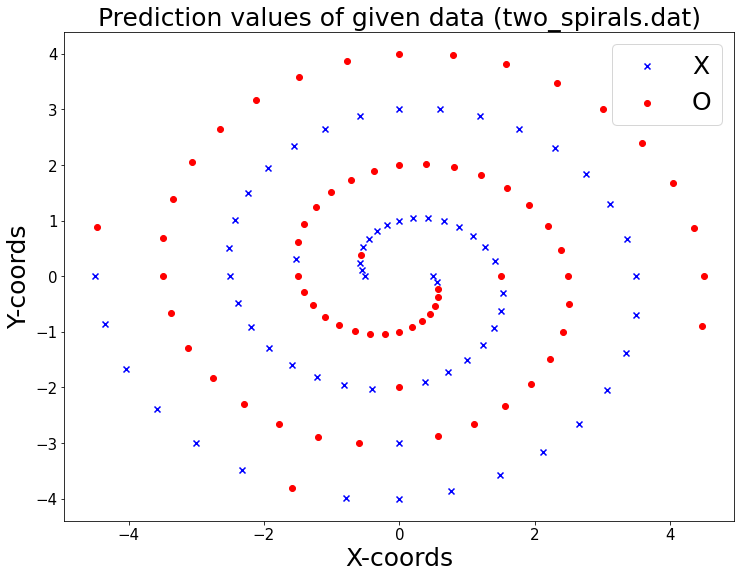

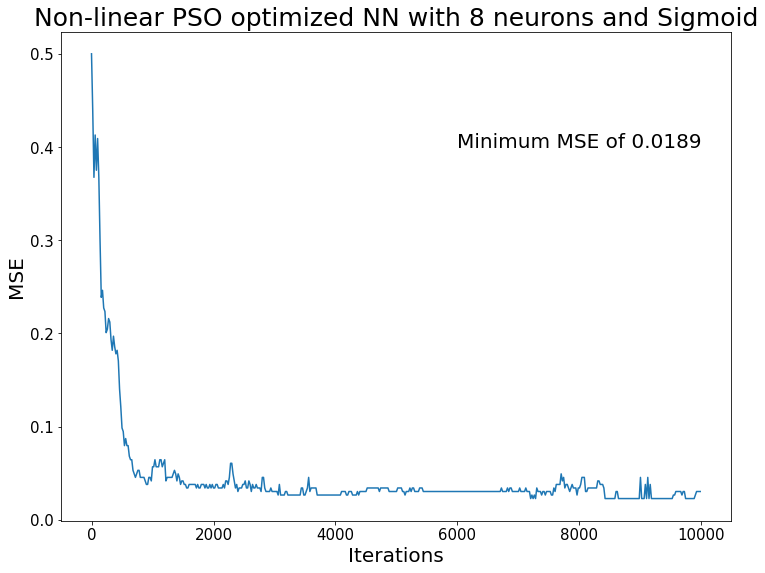

In [24]:

x1=[]
y1=[]
x2=[]
y2=[]
for i in range(len(X_train)):
    if(yArray.T[i][0]==1):
        x1.append(X[i][0])
        y1.append(X[i][1])
    else:
        x2.append(X[i][0])
        y2.append(X[i][1])
plt.scatter(x1,y1,c="b",marker = "x",label="X")
plt.scatter(x2,y2,c="r",marker="o",label="O")
plt.title("Prediction values of given data (two_spirals.dat)",fontsize=25)
plt.xlabel("X-coords",fontsize=25)
plt.ylabel("Y-coords",fontsize=25)
plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("figs/Prediction.png")  
plt.show()


points = np.arange(iterations)
plt.plot(points[:10000:20],arrays[0][0][:10000:20])
plt.xlabel("Iterations",fontsize=20)
plt.ylabel("MSE",fontsize=20)
plt.title("Non-linear PSO optimized NN with 8 neurons and Sigmoid",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(6000,0.4,f"Minimum MSE of {np.round(min(arrays[0][0]),4)}",fontsize=20)
plt.savefig("Non linear.png")
plt.show()

[ 4.47485    -0.89004    20.02428252  0.7921712  -0.97192002 -0.77709692]
(132, 2) (264, 2)


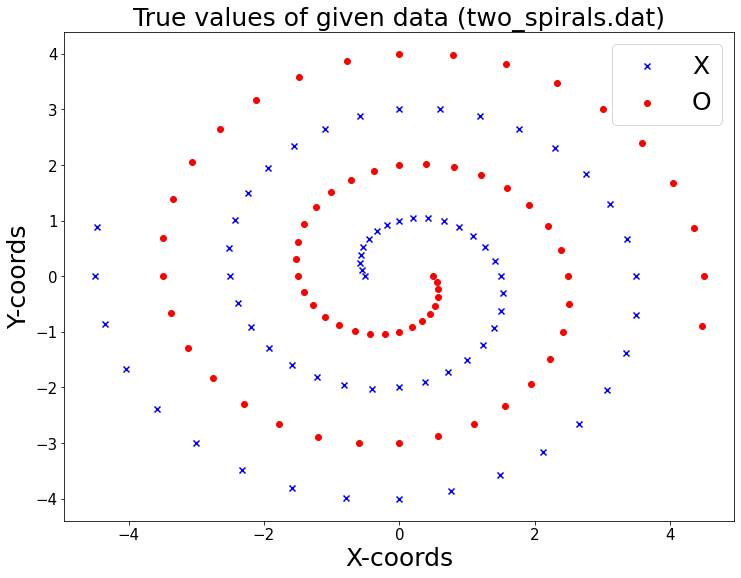

(132, 6) (132,)


In [11]:
X = data[:,0:2]
y = data[:,2]
y = y.astype(int)

X_train,X_test,y_train,y_test=generateData(X,y,0.5,True,True)
# # Load MNIST digits from sklearn

# num_classes = 10
# mnist = sklearn.datasets.load_digits(num_classes)
# X, X_test, y, y_test = sklearn.model_selection.train_test_split(mnist.data, mnist.target)

num_inputs = X.shape[1]
y_true = np.zeros((len(y), num_classes))

for i in range(len(y_train)):
    y_true[i, y[i]] = 1
  #  print(y_true[i],y[i])

y_test_true = np.zeros((len(y_test), num_classes))
for i in range(len(y_test)):
    y_test_true[i, y_test[i]] = 1

# print("y test shap e= ", y_test.shape)
# print("y true shape = ",y_true.shape)
# print("y test true shape = ",y_test_true.shape)
# print(X_test.shape)
# print(X_train.shape)

print(y_test_true.shape,y_true.shape)
plt.rcParams["figure.figsize"] = (12,9)
#print(len(X))

x1=[]
y1=[]
x2=[]
y2=[]
for i in range(len(X_train)):
    if(y_true[i][0]==1):
        x1.append(X[i][0])
        y1.append(X[i][1])
    else:
        x2.append(X[i][0])
        y2.append(X[i][1])
plt.scatter(x1,y1,c="b",marker = "x",label="X")
plt.scatter(x2,y2,c="r",marker="o",label="O")
plt.title("True values of given data (two_spirals.dat)",fontsize=25)
plt.xlabel("X-coords",fontsize=25)
plt.ylabel("Y-coords",fontsize=25)
plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("figs/TrainValues.png")  

plt.show()
y=y_train
X=X_train
print(X.shape,y.shape)


In [48]:
iterations = 200

def training(shape,activationLayer,pop):
    print("input  :",X.shape,y_true.shape)
    cost_func = functools.partial(eval_neural_network, shape=shape, X=X, y=y_true.T,activationLayer=activationLayer)

    swarm = pso.ParticleSwarm(cost_func, num_dimensions=dim_weights(shape), num_particles=pop,chi=0.729845 ,phi_p=2.0550,phi_g=2.0550)
  #  swarm = pso.ParticleSwarm(cost_func, num_dimensions=dim_weights(shape), num_particles=40,chi=0.729845 ,phi_p=1.5,phi_g=0.9)
   
    # Train...
    i = 0
    best_scores = [(i, swarm.best_score)]
    #print_best_particle(best_scores[-1])
    
    trainingLoss = []
    testloss = []
    while swarm.best_score>1e-6 and i<iterations:
        swarm._update()
        i = i+1
        
        best_weights = vector_to_weights(swarm.g, shape)
        best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)
        y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)
        testError = sklearn.metrics.mean_squared_error((y_test_true.T),y_test_pred)
        trainingLoss.append(swarm.best_score)
        testloss.append(testError)
    
#     print("Best train = ",best_scores[-1][1])
#     print("Best test = ",testLoss[-1])
    best_weights = vector_to_weights(swarm.g, shape)
    best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)
    y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)

   # accuracyError = (sklearn.metrics.accuracy_score(y_test_true, y_test_pred.T))
   # print(f"Accuracy error for {activationLayer} = {accuracyError}")
    return testloss,y_test_pred
shape=(num_inputs,8,num_classes)
testLoss,y_test_pred= training(shape,"sigmoid",30)


input  : (132, 6) (264, 2)


ValueError: shapes (8,3) and (7,132) not aligned: 3 (dim 1) != 7 (dim 0)

In [30]:
shape=(num_inputs,8,num_classes)
# activationLayer="relu"
# testLoss = training(shape,activationLayer)
# points = np.arange(iterations)
# plt.plot(points[4:],testLoss[4:])
# pl
# import time
# h=10
# pop=10
# best = np.zeros(iterations)
# minimum = np.ones(iterations)*100
# for i in range(12):
#     t1=time.time()
#     testLoss= training(shape,"sigmoid",pop)
#     print(f"Test loss for {pop} population = {testLoss[-1]} and time taken is {time.time()-t1}")
#     pop+=h
#     if(testLoss[-1]<minimum[-1]):
#         minimum = testLoss
# import time
# pop = 5
# h=5
# for i in range(40):
#     t1=time.time()
#     testLoss,y_test_pred= training(shape,"sigmoid",pop)
#     print(f"Test loss for population: {pop} = {np.amin(testLoss)} and time taken = {time.time()-t1}")
#     pop+=h
pop=40
testLoss,y_test_pred= training(shape,"sigmoid",pop)
print(f"Test loss for population: {pop} = {np.amin(testLoss)}")
points = np.arange(iterations)
plt.plot(points,testLoss)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#0.08712121212121213 for default

ValueError: shapes (8,3) and (7,132) not aligned: 3 (dim 1) != 7 (dim 0)

In [17]:
activations = ['sigmoid','tanh','relu','identity']#,'relu','default']
#iterations = 10000

def testRun():
    '''
    I want mse to be y axis
    I want neurons to be x axis
    then I will have 3 plots, tanh, sigmoid and relu?
    '''
    #shape = (num_inputs, 8, num_classes)

    neurons = [4,5,6,7,8]
    arrays = np.zeros(shape=(len(activations),len(neurons),iterations))
    minError = 100000
    yArray=[]
    for i in range(len(arrays)):
        activationLayer = activations[i]
        for k in range(len(neurons)):
            shape = (num_inputs,neurons[k],num_classes)
            mse,ys = training(shape,activationLayer,40)
            arrays[i][k]=mse
            
            if mse[-1]<minError:
                minError=mse[-1]
                yArray=ys
            
            print(f"Activation = {activations[i].capitalize()} neurons = {neurons[k]} with mse of {mse[-1]}")
     #   print(i)
    
    return arrays,yArray
arrays,yArray = testRun()

ValueError: shapes (4,3) and (7,132) not aligned: 3 (dim 1) != 7 (dim 0)

In [71]:
plt.rcParams["figure.figsize"] = (12,9)

x1=[]
y1=[]
x2=[]
y2=[]
y_test_pred=yArray.T
for i in range(len(X_test)):
    if(y_test_pred[i][0]==1):
        x1.append(X[i][0])
        y1.append(X[i][1])
    else:
        x2.append(X[i][0])
        y2.append(X[i][1])
plt.scatter(x1,y1,c="b",marker = "x",label="X")
plt.scatter(x2,y2,c="r",marker="o",label="O")
plt.title("Plotting the predictions from the best NN structure",fontsize=25)
plt.xlabel("X-coords",fontsize=25)
plt.ylabel("Y-coords",fontsize=25)
plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("figs/SpiralPlot.svg")  
plt.show()

NameError: name 'yArray' is not defined

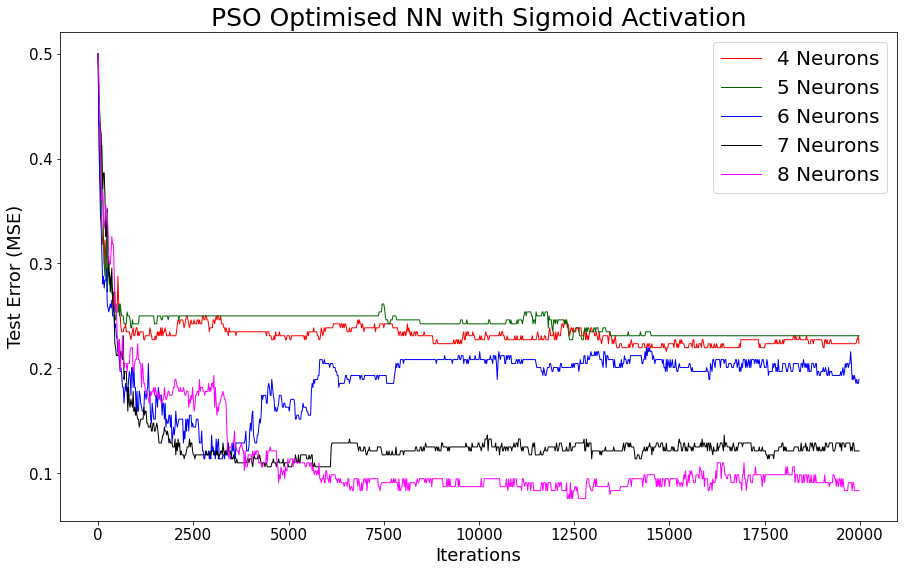

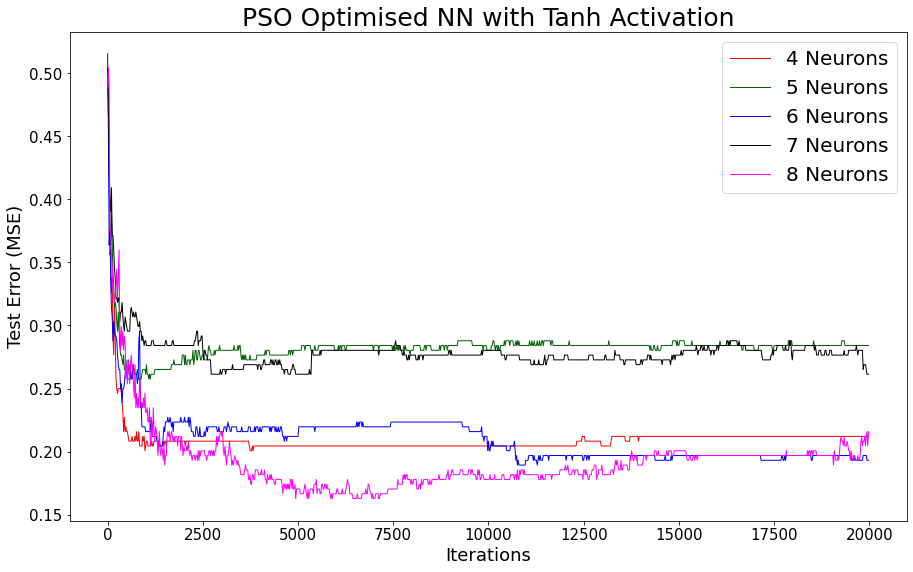

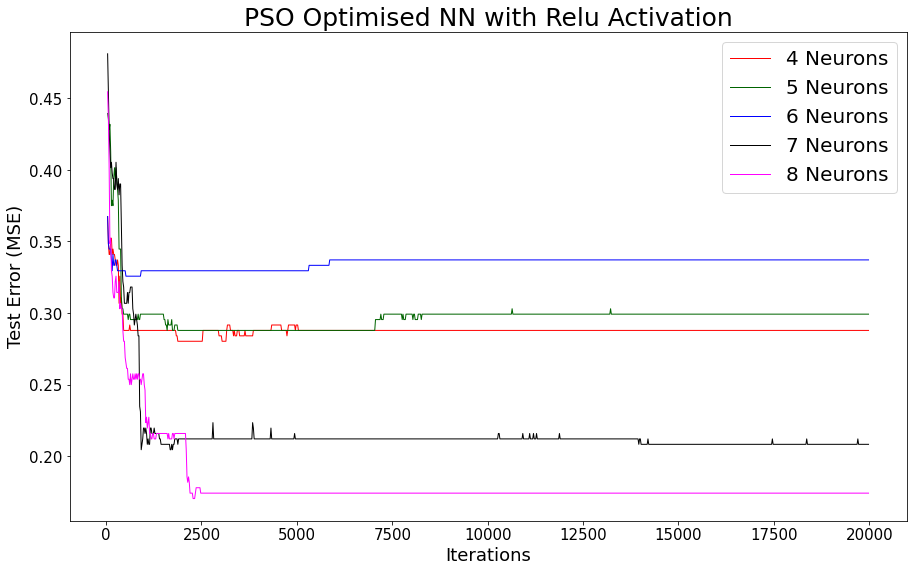

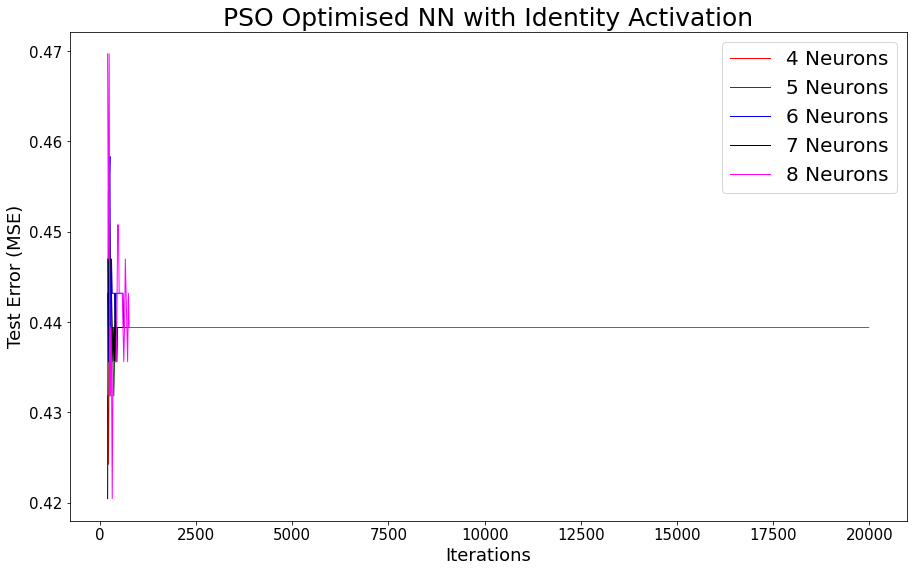

0.07196969696969698


In [79]:
neurons = [4,5,6,7,8]
points = np.arange(iterations)
colors = ['r','darkgreen','b','k','fuchsia']
stepSize = 20
plt.rcParams["figure.figsize"] = (15,9)

for i in range(len(activations)):
    for k in range(len(neurons)):
        if activations[i]=="relu":
            plt.plot(points[40::stepSize],arrays[i][k][40::stepSize],color=colors[k],label= "{0} Neurons".format(neurons[k]),linewidth=1)
        elif activations[i]=="identity":
            plt.plot(points[200::stepSize],arrays[i][k][200::stepSize],color=colors[k],label= "{0} Neurons".format(neurons[k]),linewidth=1)

        else:
            plt.plot(points[::stepSize],arrays[i][k][::stepSize],color=colors[k],label= "{0} Neurons".format(neurons[k]),linewidth=1)
    #plt.yticks(np.arange(0, 10, 20))  

    #  plt.figure(figsize=(12,12))
    #plt.xticks(np.arange(0,, 5))
    plt.title(f"PSO Optimised NN with {activations[i].capitalize()} Activation",fontsize=25)
    plt.legend(fontsize=20)    
    plt.xlabel("Iterations",fontsize=18)
    plt.ylabel("Test Error (MSE)",fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("figs/{0}.svg".format(activations[i].capitalize()))  

    plt.show()

print(np.amin(arrays))

In [73]:
#for svg the best is 0.06


# neurons = [4,5,6,7,8]
# plt.figure(figsize=(7,7))
# plt.plot(neurons,arrays[1],color='r',label="tanh")
# plt.plot(neurons,arrays[0],color='g',label="sigmoid")
# #plt.plot(neurons,arrays[2],color='c',label="relu")
# #plt.plot(neurons,arrays[3],color='b',label="Identity")
# plt.xlabel("Neurons")
# plt.ylabel("Test error: MSE")
# plt.legend()
# plt.show()
# print("hello")

In [ ]:
'''
Using the brute force method figure out the optimal functions

then use the same functions in PSO and compare it with base line

'''

In [ ]:
shape = (2,5,2)
dim =dim_weights(shape)
particles = 30
X = np.random.uniform(low=-100,high=100,size=(particles, dim))
X

In [ ]:
np.random.seed(2)
